In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import cv2

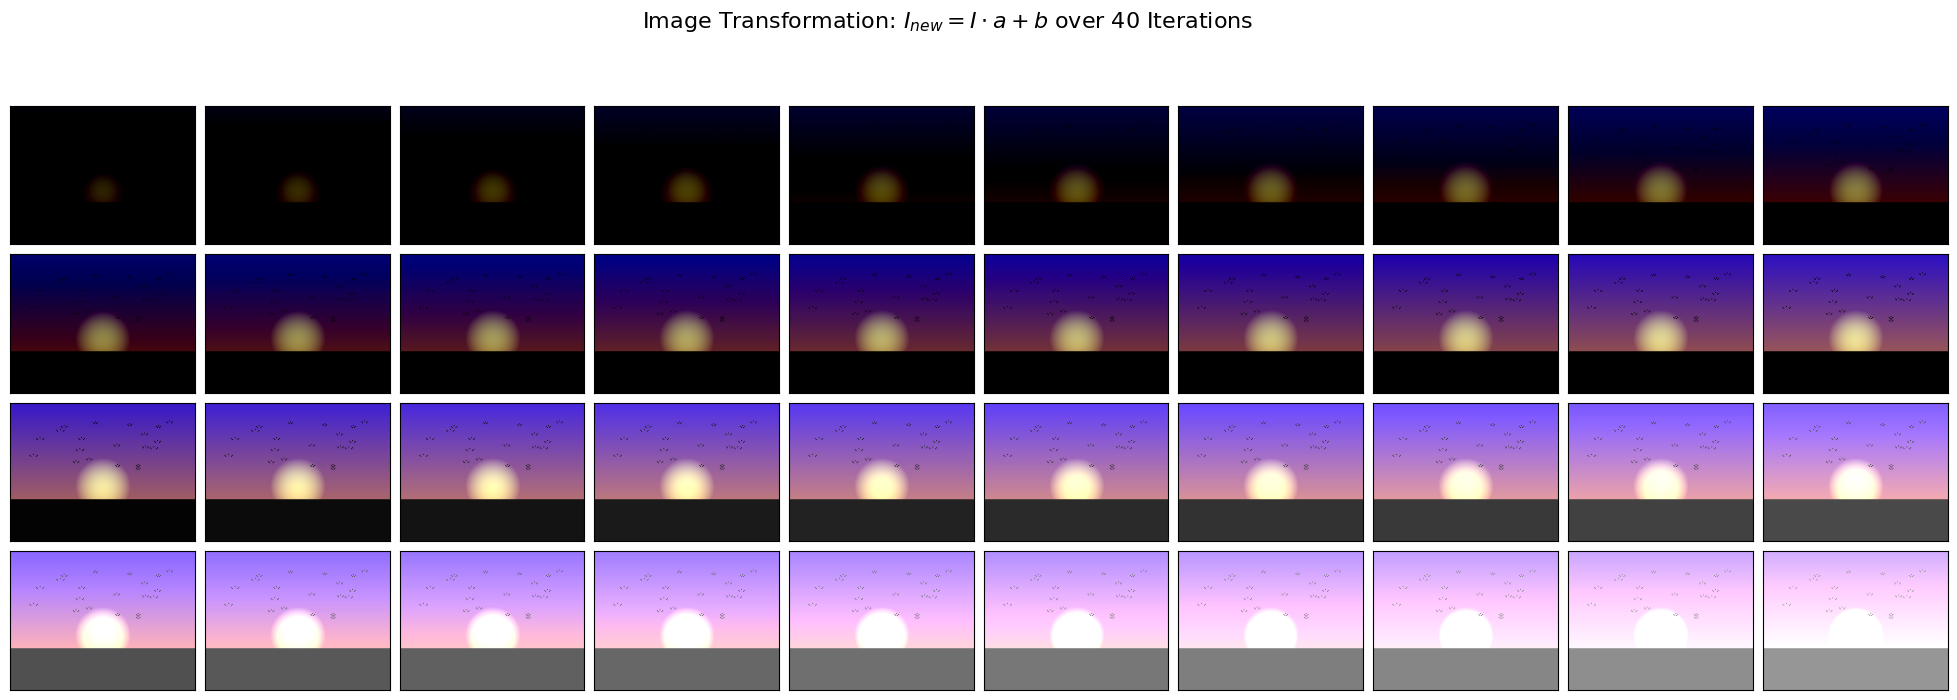

In [2]:
# --- 1. Create a Base Synthetic Sunset-like Image ---
def create_synthetic_sunset(width=200, height=150):
    """
    Creates a synthetic image resembling a sunset with a silhouette foreground.
    """
    img = np.zeros((height, width, 3), dtype=np.float32) # Use float32 for intermediate calculations

    # Sky gradient (simulating sunset colors)
    for y in range(height):
        # Top (darker blue/purple) to bottom (orange/yellow)
        r = y / height * 255 * 0.8 + (1 - y / height) * 50 # Orange to dark
        g = y / height * 150 * 0.8 + (1 - y / height) * 20 # Yellowish to dark
        b = (1 - y / height) * 200 + y / height * 50 # Blue to reddish
        img[y, :, 0] = r
        img[y, :, 1] = g
        img[y, :, 2] = b

    # Normalize to 0-1 for easier manipulation if needed, then scale back to 0-255
    img = np.clip(img, 0, 255)

    # Sun disk (optional, centered lower)
    center_x, center_y = width // 2, int(height * 0.6)
    radius = int(width * 0.15)
    for y in range(max(0, center_y - radius), min(height, center_y + radius)):
        for x in range(max(0, center_x - radius), min(width, center_x + radius)):
            dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            if dist < radius:
                # Make sun a brighter, warmer color
                intensity = 1 - (dist / radius)**2 # Fade out from center
                img[y, x, 0] = np.clip(img[y, x, 0] + intensity * 100, 0, 255) # Reddish
                img[y, x, 1] = np.clip(img[y, x, 1] + intensity * 150, 0, 255) # Yellowish
                img[y, x, 2] = np.clip(img[y, x, 2] + intensity * 50, 0, 255) # Less blue

    # Foreground silhouette (grass/trees/birds)
    for y in range(int(height * 0.7), height):
        img[y, :, :] *= (1 - (y - height * 0.7) / (height * 0.3)) * 0.1 # Fade to black
        img[y, :, :] = np.clip(img[y, :, :] - 100, 0, 255) # Make darker

    # Add some random bird-like shapes
    num_birds = 20
    for _ in range(num_birds):
        bx = np.random.randint(width * 0.1, width * 0.9)
        by = np.random.randint(height * 0.1, height * 0.5)
        # Simple V-shape for birds
        bird_size = np.random.randint(2, 5)
        if by + bird_size < height and bx + bird_size < width and bx - bird_size >= 0:
            img[by, bx, :] = 0 # Black dot
            img[by + 1, bx - bird_size, :] = 0
            img[by + 1, bx + bird_size, :] = 0
            img[by + 2, bx - bird_size + 1, :] = 0
            img[by + 2, bx + bird_size - 1, :] = 0


    return img.astype(np.uint8) # Convert to 8-bit unsigned integer

# Base image (the 'I' in the equation)
base_image = create_synthetic_sunset(width=200, height=150) # Smaller for faster processing

# Convert base image to float for calculations to prevent overflow/underflow during I*a+b
# Important: ensure the data type can handle values outside 0-255 during calculation
base_image_float = base_image.astype(np.float32)

# --- 2. Define Iteration Parameters ---
num_iterations = 40 # As per the reference output, using 40 iterations
# Ensure at least 20 iterations as requested

# Define ranges for a and b
# 'a' will control contrast. Let's make it subtly increase or stay near 1.
# 'b' will control brightness. This will be the primary driver for the dark to light transition.
a_start, a_end = 0.8, 1.2 # From slightly lower contrast to slightly higher
b_start, b_end = -150, 150 # From very dark to very bright

# --- 3. Perform Iterations and Store Images ---
generated_images = []

for i in range(num_iterations):
    # Linear interpolation for 'a' and 'b' values
    # Progress from 0 to 1 over the iterations
    progress = i / (num_iterations - 1)

    a = a_start + (a_end - a_start) * progress
    b = b_start + (b_end - b_start) * progress

    # Apply the linear equation: I_new = I * a + b
    # Ensure to perform calculation on float type
    transformed_image_float = base_image_float * a + b

    # Clip values to the valid 0-255 range and convert back to uint8
    transformed_image_uint8 = np.clip(transformed_image_float, 0, 255).astype(np.uint8)

    generated_images.append(transformed_image_uint8)

# --- 4. Plot with ImageGrid ---
rows = 4
cols = 10

if len(generated_images) != rows * cols:
    print(f"Warning: Number of generated images ({len(generated_images)}) does not match grid size ({rows * cols}). Adjusting grid or padding.")
    # If not enough images, pad with the last generated image
    if len(generated_images) < rows * cols:
        last_image = generated_images[-1]
        while len(generated_images) < rows * cols:
            generated_images.append(last_image)
    # If too many images, truncate
    else:
        generated_images = generated_images[:rows * cols]

fig = plt.figure(figsize=(cols * 2.5, rows * 2)) # Adjust figure size for better visual
# Grid definition: nrows_ncols= (rows, columns)
# axes_pad: pad between axes in inch.
# cbar_mode: 'single', 'edge', or None for colorbar (not needed here)
grid = ImageGrid(fig, 111,
                 nrows_ncols=(rows, cols),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, generated_images):
    # Matplotlib expects RGB, but if using OpenCV's imread, it's BGR.
    # Our synthetic image is already created as RGB-like, so direct imshow is fine.
    # If you load an image with cv2.imread(), remember to convert: im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax.imshow(im)
    ax.set_xticks([]) # Hide ticks for clean display
    ax.set_yticks([]) # Hide ticks

fig.suptitle(r'Image Transformation: $I_{new} = I \cdot a + b$ over 40 Iterations', fontsize=16)
plt.show()

# Optional: Save the grid image
# plt.savefig("linear_equation_image_grid.png", bbox_inches='tight', dpi=300)